# Standard coalescent

In [1]:
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis

Skipping install of 'ptdalgorithms' from a local remote, the SHA1 (1.0.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
# remove.packages("ptdalgorithms")

In [4]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [5]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [6]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [7]:
Rcpp::sourceCpp("./cpp/coalescent.cpp")

In [8]:
source("plot_functions.R")

In [9]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(family="Arial"))

In [10]:
# p <- ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species)) + despine

# ggplotly(width=600, height=400)

In [11]:
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(size=17)) 

options(repr.plot.width=10, repr.plot.height=7)

# ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species), size=5, alpha=0.5) + scale_color_brewer(palette="Set1") + despine

# Issue: after expectation is run, gam$SIM doubles, fix or tell user not to reuse graph_as_matrix(graph) as matrix result

```
graph <- standard_coalescent(4)
print(graph_as_matrix(graph))
expectation(graph)
print(graph_as_matrix(graph))
```

## Generate standard coalescent state space

If you want to generate the state space:

In [12]:
standard_coalescent <- function(n) {
    
    # n <- 4
      
    state_vector_length <- n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
          
      index <- index + 1
    }
    return(graph)
}
# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

In [13]:
state_space <- function(initial_state, fun, ...) {
    
    graph <- create_graph(length(initial_state))
    starting_vertex <- vertex_at(graph, 1)
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2

    while (index <= vertices_length(graph)) {
      print(c(index, vertices_length(graph)))
      vertex <- vertex_at(graph, index)
      state <- vertex$state

      result <- fun(state, graph=graph, ...)

      if (length(result$states) > 0) {
        for (i in 1:length(result$states)) {
            add_edge(
              vertex,
              find_or_create_vertex(graph, c(result$states[[i]])),
              c(result$rates[[i]]), c(result$rates[[i]])
            )
        }
      }
      index <- index + 1
   }
   return(graph)
}



# just give the state_space function an initial state, 
# a callback function and any arguments the callback function
# that takes a "state" and "graph" argument and any other
# arguments passed state_space:

n <- 4
initial_state = rep(0, n)
initial_state[1] <- n

graph <- state_space(initial_state, kingman, n)
graph

[1] 2 2


ERROR: Error in eval(expr, envir, enclos): objekt 'kingman' blev ikke fundet


------

Just checking if I can do a "first-row solve" that is faster than R's solve.

In [128]:
graph <- standard_coalescent(7)
gam <- graph_as_matrix(graph)
nr_states <- nrow(gam$states)

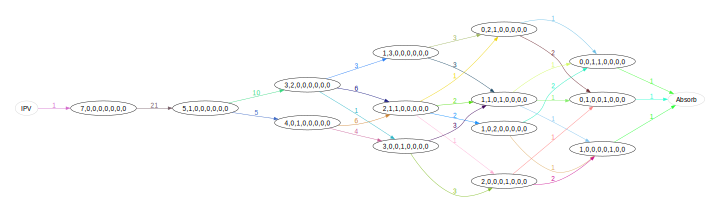

In [129]:
plot_graph(graph_as_matrix(graph), size=c(10, 10), align=TRUE, rainbow=TRUE,
               fontsize=16, ranksep=1, nodesep=0.5)
         

In [130]:
residence_times <- function(graph) {
    res <- rep(0, vertices_length(graph))
    res[1] <- expectation(graph)
    sca <- rep(0, vertices_length(graph))
    sca[1] <- 1
    start_idx <- starting_vertex(graph)$index
    for (vertex in vertices(graph)) {
        idx <- vertex$index
        pushed <- 0
        for (edge in edges(vertex)) {
            child_idx <- edge$child$index
            child_prob <- edge$weight / vertex$rate
            wt <- 1/vertex$rate * sca[idx]            
            # if (vertex$index == 1) {
            if (idx == start_idx) {
                wt <- 0
            } 
            if (length(edges(edge$child)) > 0) { # don't push to absorbing
                push <- (res[idx] - wt) * child_prob
                res[child_idx] <- res[child_idx] + push
                sca[child_idx] <- sca[child_idx] + sca[idx] * child_prob
                pushed <- pushed + push
            }
        }
        res[idx] <- res[idx] - pushed
    }
    return(res)
}
#residence_times(graph)

---

In [118]:
# with 4x4 matrix
a <- c(2, 1, 3, 3) 
b <- c(5, 3, 5, 4) 
c <- c(6, 5, 9, 6)
d <- c(1, 3, 2, 2)
xyz <- rbind(a, b, c, d) 
print(xyz)
solve(a=xyz) 

  [,1] [,2] [,3] [,4]
a    2    1    3    3
b    5    3    5    4
c    6    5    9    6
d    1    3    2    2


a,b,c,d
-0.2702703,0.56756757,-0.18918919,-0.1621622
-0.3243243,0.08108108,-0.02702703,0.4054054
-0.1621622,-0.45945946,0.48648649,-0.2972973
0.7837838,0.05405405,-0.35135135,0.2702703


In [116]:
# with 4x4 matrix
a <- c(2, 1, 3, 3) 
b <- c(5, 3, 5, 4) 
c <- c(6, 5, 9, 6)
d <- c(1, 3, 2, 2)
xyz <- rbind(a, b, c, d) 
m <- matrix(0, nrow=4, ncol=4)
diag(m) <- 1
solve(a=xyz) %*% m #%*% rep(1, 4)


-0.2702703,0.56756757,-0.18918919,-0.1621622
-0.3243243,0.08108108,-0.02702703,0.4054054
-0.1621622,-0.45945946,0.48648649,-0.2972973
0.7837838,0.05405405,-0.35135135,0.2702703


---

In [138]:
start <- proc.time()[3]
v <- residence_times(matrix_as_graph(gam$IPV, gam$SIM))
first_row_U_ptd <- v[2:(length(v)-1)]
proc.time()[3] - start
#first_row_U_ptd

elapsed 
  0.003

In [139]:
# start <- proc.time()[3]
# v <- accumulated_visiting_time(graph, 100)
# #v
# first_row_U_ptd_acc <- v[2:(length(v)-1)]
# proc.time()[3] - start

In [140]:
# (first_row_U_ptd - first_row_U_ptd_acc)/first_row_U_ptd_acc

In [141]:
# max(abs((first_row_U_ptd - first_row_U_ptd_acc)/first_row_U_ptd_acc))

In [142]:
start <- proc.time()[3]
first_row_U_solve <- -solve(gam$SIM)[1, ]
first_row_U_solve
proc.time()[3] - start

[1] 0.04761905 0.06666667 0.06666667 0.03333333 0.03333333 0.10000000
 [7] 0.03333333 0.06666667 0.06666667 0.13333333 0.06666667 0.33333333
[13] 0.33333333 0.33333333

elapsed 
  0.006

In [143]:
(first_row_U_ptd - first_row_U_solve)/first_row_U_solve

[1]  1.165734e-15  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
 [6] -2.775558e-16  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
[11]  0.000000e+00 -3.330669e-16 -1.665335e-16 -1.665335e-16

In [144]:
max(abs((first_row_U_ptd - first_row_U_solve)/first_row_U_solve))

[1] 1.165734e-15